In [1]:
!pip install torch torchvision stable-baselines3 matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 17.2 MB/s eta 0:00:00


In [2]:
!pip uninstall -y gym

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = SimpleCNN().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)


for epoch in range(10):
    cnn.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = cnn(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]


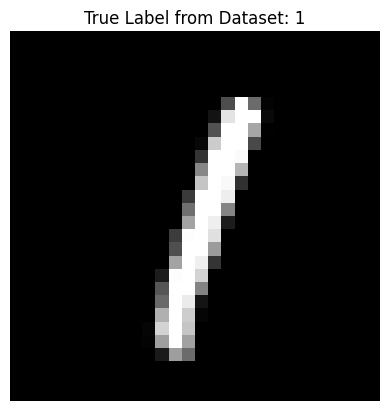

the true number id : 1


In [6]:
import matplotlib.pyplot as plt

img, label = test_data[5]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"True Label from Dataset: {label}")
plt.axis("off")
plt.show()
img = img.to(device)
print(f"the true number id : {label}")


In [7]:
img_tensor = img.unsqueeze(0).to(device)

with torch.no_grad():
    prediction_before = cnn(img_tensor).argmax().item()

print("Prediction BEFORE attack:", prediction_before)


Prediction BEFORE attack: 1


In [35]:
def fgsm_attack(image, epsilon, data_grad):
    sign_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# اختبر على صورة واحدة
img, label = test_data[5]
img = img.to(device).clone().detach().requires_grad_(True)

output = cnn(img.unsqueeze(0))
print("Before attack:", output.argmax().item())

loss = F.cross_entropy(output, torch.tensor([label]).to(device))
loss.backward()

# نفذ التشويش
perturbed_img = fgsm_attack(img, epsilon=0.1, data_grad=img.grad.data)

# راقب النتيجة
new_output = cnn(perturbed_img.unsqueeze(0))
print("After attack:", new_output.argmax().item())

Before attack: 1
After attack: 1


In [59]:
class MNISTAttackEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, model, original_image, true_label, epsilon=0.3):
        super().__init__()
        self.model = model.eval()
        self.original_image = original_image.clone().detach()
        self.image = original_image.clone().detach()
        self.true_label = true_label
        self.epsilon = epsilon
        self.max_steps = 75
        self.step_count = 0

        # Action space: perturbation values in the range [-1, 1] for each pixel in the 28x28 image
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(28, 28), dtype=np.float32)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1, 28, 28), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.image = self.original_image.clone().detach()
        self.step_count = 0

        # ✅ FGSM perturbation (هجوم خفيف ذكي ببداية كل حلقة)
        self.image.requires_grad = True
        output = self.model(self.image.unsqueeze(0))
        loss = F.cross_entropy(output, torch.tensor([self.true_label]).to(self.image.device))
        self.model.zero_grad()
        loss.backward()
        data_grad = self.image.grad.data

        fgsm_eps = 0.05
        sign_data_grad = data_grad.sign().squeeze()
        perturbed_image = self.image + fgsm_eps * sign_data_grad
        self.image = torch.clamp(perturbed_image, 0, 1).detach()

        return self.image.cpu().numpy(), {}

    def step(self, action):
        action = np.clip(action, -1.0, 1.0)
        perturbation = torch.tensor(action, dtype=torch.float32).to(self.image.device) * 0.6
        self.image = torch.clamp(self.image + perturbation, 0, 1)

        output = self.model(self.image.unsqueeze(0))
        pred = output.softmax(dim=1)
        pred_label = pred.argmax(dim=1).item()

        perturbation_norm = torch.norm(perturbation)
        total_perturbation = torch.norm(self.image - self.original_image)
        confidence_wrong = 1.0 - pred[0, self.true_label].item()

        if pred_label != self.true_label:
            reward = 3.0 + confidence_wrong - 0.6 * total_perturbation.item()
            if total_perturbation.item() < 0.5:
                reward += 1.0  # 🎯 هجوم نضيف = مكافأة إضافية
        else:
            reward = -0.5 + 0.8 * confidence_wrong - 0.3 * perturbation_norm.item()

        self.step_count += 1
        done = pred_label != self.true_label or self.step_count >= self.max_steps or total_perturbation.item() > 1.5

        print(f"Reward: {reward:.3f} | Total Perturb: {total_perturbation.item():.3f} | Predicted: {pred_label}")

        return self.image.cpu().numpy(), reward, done, False, {}

    def render(self):
        import matplotlib.pyplot as plt
        plt.imshow(self.image.cpu().numpy().reshape(28, 28), cmap="gray")
        plt.show()


In [34]:
env = MNISTAttackEnv(cnn, img, label)
policy_kwargs = dict(net_arch=[128, 128])

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=2.5e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    policy_kwargs=policy_kwargs
)
model.learn(total_timesteps=120000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reward: -4.140 | Total Perturb: 9.069 | Predicted: 9
Reward: -4.005 | Total Perturb: 8.682 | Predicted: 9
Reward: -4.125 | Total Perturb: 8.815 | Predicted: 9
Reward: -1.593 | Total Perturb: 9.273 | Predicted: 2
Reward: -1.393 | Total Perturb: 8.728 | Predicted: 7
Reward: -3.840 | Total Perturb: 8.774 | Predicted: 9
Reward: -4.024 | Total Perturb: 8.489 | Predicted: 9
Reward: -3.883 | Total Perturb: 9.305 | Predicted: 9
Reward: -4.128 | Total Perturb: 9.174 | Predicted: 9
Reward: -4.148 | Total Perturb: 9.202 | Predicted: 9
Reward: -3.898 | Total Perturb: 8.775 | Predicted: 9
Reward: -3.801 | Total Perturb: 9.038 | Predicted: 9
Reward: -4.203 | Total Perturb: 8.726 | Predicted: 9
Reward: -4.049 | Total Perturb: 8.835 | Predicted: 9
Reward: -1.498 | Total Perturb: 9.149 | Predicted: 3
Reward: -1.543 | Total Perturb: 8.668 | Predicted: 7
Reward: -4.072 | Total Perturb: 8.937 | Predicted: 9
Rewa

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Reward: -0.775 | Total Perturb: 7.898 | Predicted: 2
Reward: -0.303 | Total Perturb: 7.169 | Predicted: 2
Reward: -0.398 | Total Perturb: 7.330 | Predicted: 7
Reward: -0.743 | Total Perturb: 7.905 | Predicted: 7
Reward: -4.993 | Total Perturb: 7.350 | Predicted: 9
Reward: -0.757 | Total Perturb: 7.929 | Predicted: 7
Reward: -0.637 | Total Perturb: 7.729 | Predicted: 2
Reward: -0.604 | Total Perturb: 7.674 | Predicted: 2
Reward: -0.623 | Total Perturb: 7.706 | Predicted: 7
Reward: -0.578 | Total Perturb: 7.617 | Predicted: 7
Reward: -0.365 | Total Perturb: 7.275 | Predicted: 2
Reward: -0.584 | Total Perturb: 7.639 | Predicted: 7
Reward: -0.494 | Total Perturb: 7.490 | Predicted: 3
Reward: -0.541 | Total Perturb: 7.569 | Predicted: 7
Reward: -0.463 | Total Perturb: 7.436 | Predicted: 7
Reward: -0.297 | Total Perturb: 7.151 | Predicted: 7
Reward: -0.684 | Total Perturb: 7.807 | Predicted: 7
Reward: -0.815 | Total Perturb: 8.025 | Predicte

In [71]:
success_count = 0
num_images = 100

for i in range(num_images):
    img, label = test_data[i]
    img = img.to(device)

    env = MNISTAttackEnv(cnn, img, label)
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)


    with torch.no_grad():
        final_pred = cnn(torch.tensor(obs).unsqueeze(0).to(device))
        predicted_label = final_pred.argmax(dim=1).item()
        if predicted_label != label:
            success_count += 1

success_rate = success_count / num_images * 100
print(f"✅ num of tries {num_images}")
print(f"🎯 number of succssed attacks {success_count}")
print(f"📊 attack success rate: {success_rate:.2f}%")


Reward: -4.986 | Total Perturb: 8.887 | Predicted: 7
Reward: -5.090 | Total Perturb: 9.796 | Predicted: 2
Reward: -1.374 | Total Perturb: 8.945 | Predicted: 2
Reward: -1.588 | Total Perturb: 8.964 | Predicted: 2
Reward: -1.242 | Total Perturb: 8.735 | Predicted: 2
Reward: -1.397 | Total Perturb: 8.987 | Predicted: 2
Reward: -1.600 | Total Perturb: 9.332 | Predicted: 7
Reward: -1.080 | Total Perturb: 8.466 | Predicted: 2
Reward: -4.795 | Total Perturb: 8.655 | Predicted: 5
Reward: -1.148 | Total Perturb: 8.580 | Predicted: 2
Reward: -1.657 | Total Perturb: 9.336 | Predicted: 2
Reward: -4.825 | Total Perturb: 8.707 | Predicted: 6
Reward: -1.188 | Total Perturb: 8.646 | Predicted: 2
Reward: -1.879 | Total Perturb: 8.966 | Predicted: 2
Reward: -1.373 | Total Perturb: 8.830 | Predicted: 3
Reward: -1.653 | Total Perturb: 9.421 | Predicted: 3
Reward: -1.058 | Total Perturb: 8.430 | Predicted: 7
Reward: -1.567 | Total Perturb: 8.668 | Predicted: 2
Reward: -1.434 | Total Perturb: 8.973 | Predic

Reward: -5.025 | Total Perturb: 7.251 | Predicted: 9


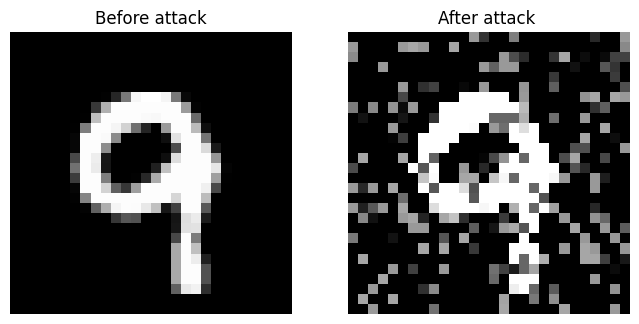

✅the predicted is : 9
❌ Attack failed


In [74]:
pobs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Before attack")
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("After attack ")
plt.imshow(obs.squeeze(), cmap='gray')
plt.axis("off")
plt.show()


with torch.no_grad():
    final_pred = cnn(torch.tensor(obs).unsqueeze(0).to(device))
    predicted_label = final_pred.argmax(dim=1).item()
    print(f"✅the predicted is : {predicted_label}")
    print(f"{'🛑 Attack succsse!' if predicted_label != label else '❌ Attack failed'}")
